In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats.mstats import mquantiles
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/tmp/ipykernel_27919/2937145936.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Import custom quantile regression models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import qr_models as qr

## Data set

In this workbook, we will use a real data set about concrete compressive strength.
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.
	
This dataset was taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

In [3]:
dataset = pd.read_csv('../data/Concrete_Data.csv', header=0)
dataset

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Make a test set

We consider the problem of predicting Y | X.

We will hold out some of the observations for testing.

In [4]:
# Set a random seed for reproducibility
np.random.seed(2023)

# Designate a test set
X_data, X_test, Y_data, Y_test = train_test_split(dataset.iloc[:,:-1].values, dataset.iloc[:,-1].values, test_size=0.2, random_state=2023)

print("Number of explanatory variables: {:d}.".format(X_data.shape[1]))
print("Number of data points: {:d}.".format(X_data.shape[0]))
print("Number of test points: {:d}.".format(len(Y_test)))

Number of explanatory variables: 8.
Number of data points: 824.
Number of test points: 206.


Let's make a histogram of the Y values.

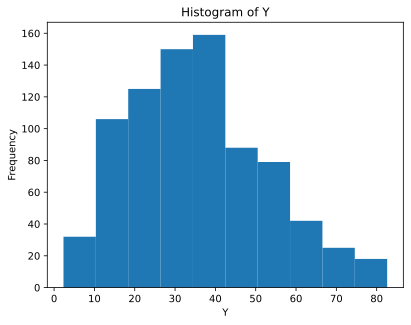

In [5]:
plt.hist(Y_data)
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Histogram of Y")
plt.show()

## Machine learning predictions

We can try to predict the compressive strength using a random forest regression model.

In [6]:
# Initialize a random forest object
from sklearn.ensemble import RandomForestRegressor
black_box = RandomForestRegressor(n_estimators=10, min_samples_split=5, random_state=2023)

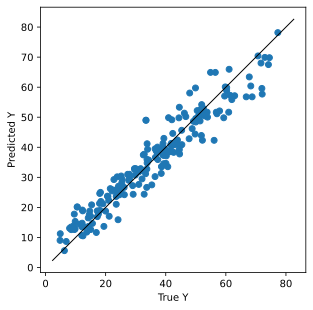

In [7]:
# Fit the black-box model on all data points
black_box.fit(X_data, Y_data)

# Make predictions on test data
Y_hat = black_box.predict(X_test)

# Compare test points to predicted values
y_min = np.minimum(np.min(Y_hat),np.min(Y_data))
y_max = np.maximum(np.max(Y_hat),np.max(Y_data))
plt.plot([y_min, y_max], [y_min, y_max], color = 'black', linewidth = 1)
plt.scatter(Y_test, Y_hat)
plt.axis('square')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.show()

## Naive prediction intervals based on in-sample residuals

In [8]:
def naive_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute naive prediction bands based on the distribution of
      residuals within the training data set
      
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Fit the black box model on the training data
    black_box.fit(X, Y)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y - black_box.predict(X))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [9]:
def evaluate_predictions(lower, upper, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of regression predictions
    Computes:
    - marginal coverage
    - average size of sets
    
    Input
    lower     : n x 1 vector of prediction lower bounds
    upper     : n x 1 vector of prediction upper upper
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Number of samples
    n = len(Y)
    
    # Evaluate the empirical coverage
    covered = (Y>=lower) * (Y <= upper)

    # Compute marginal coverage
    marginal_coverage = np.mean(covered)
    
    # Compute average size of prediction sets
    size = np.mean(upper-lower)
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where(covered)[0]
    size_cover = np.mean(upper[idx_cover]-lower[idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('Average length          : {:2.3f}'.format(size))
        
    return marginal_coverage, size

In [10]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 66.990%
Average length          : 9.118


## Conformal prediction via conditional mean regression

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Choose a black-box machine learning model (1,2,3,4)
bb_model_index = 1

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=10, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

In [12]:
def conformal_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the black box model on the training data
    black_box.fit(X_train, Y_train)
    
    # Compute residuals on the calibration data
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [13]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 92.718%
Average length          : 23.954


## Cross-validation+

In [16]:
from sklearn.model_selection import KFold
import copy
import pdb

def cv_prediction_intervals(X, Y, X_test, black_box, alpha, K, random_state=2023):
    """
    Compute CV+ version of quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X            : n x p data matrix of explanatory variables
    Y            : n x 1 vector of response variables
    X_test       : n x p test data matrix of explanatory variables
    black_box    : sklearn model object with 'fit' and 'predict' methods
    alpha        : 1 - target coverage level 
    K            : number of folds
    random_state : random seed for replicability (default: 2023)
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    q_hat = [ copy.deepcopy(black_box.fit(X[train_index], Y[train_index])) 
             for train_index, _ in cv.split(X) ]
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = None # This should be a vector of indices corresponding to the hold-out points
        """TODO: write your code here (1 lines)"""
        
        # Evaluate point predictions for hold-out data
        y_hat = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (1 line)"""
        
        # Compute conformity scores for this fold
        Z_fold = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (1 line)"""
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate point predictions for hold-out data
        y_hat = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = None # This should be a vector of indices corresponding to the hold-out points
            """TODO: write your code here (1 lines)"""
            
            # Evaluate point predictions for hold-out data
            y_hat = None # This should be a vector of the same length as idx_calib
            """TODO: write your code here (1 line)"""
            
        # CV+ upper limit for this point
        upper[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
        
        # CV+ lower limit for this point
        lower[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
    
    return lower, upper 

In [17]:
# Apply CV+
K = 10
lower, upper = cv_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, K)

# Evaluate performance
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

> /tmp/ipykernel_27919/618165185.py(44)cv_prediction_intervals()
     42 
     43     # Compute conformity scores on hold-out data for each fold
---> 44     Z = np.zeros(len(Y))
     45     for k in range(K):
     46 

ipdb> q_hat
[RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split=10, n_estimators=10, random_state=2023), RandomForestRegressor(min_samples_split

## Numerical experiments

We will now repeatedly apply the two methods described above to the data set, each time using a different random subset of the data for testing.

In [ ]:
def run_experiment_cv(dataset, K, random_state=2023):
    # Divide data
    X_data, X_test, Y_data, Y_test = train_test_split(dataset.iloc[:,:-1].values, dataset.iloc[:,-1].values, 
                                                      test_size=0.2, random_state=random_state)
    
    
    # Run and evaluate split conformal CQR
    lower_sc, upper_sc = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, random_state=random_state)
    metrics_sc = evaluate_predictions(lower_sc, upper_sc, X_test, Y_test, verbose=False)
    
    # Run and evaluate CV+
    lower_cv, upper_cv = cv_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, K, random_state=random_state)
    metrics_cv = evaluate_predictions(lower_cv, upper_cv, X_test, Y_test, verbose=False)
    
    # Return results
    results_exp = pd.DataFrame({"Method":["Split", "CV+"], 
                                "Coverage":[metrics_sc[0], metrics_cv[0]],
                                "Length":[metrics_sc[1], metrics_cv[1]],
                  })
    return results_exp

In [ ]:
# Run many experiments
results_cv = pd.DataFrame()

for experiment in tqdm(range(50)):
    
    # Random state for this experiment
    random_state = 2023 + experiment
    
    # Run the experiment
    
    result_exp = run_experiment_cv(dataset, K=10, random_state=random_state)
    
    # Store results
    results_cv = pd.concat([results_cv,result_exp])

In [ ]:
import seaborn as sns

# Prepare to make side-to-side plots
plt.figure(figsize=(12,3.5))

# Compare marginal coverage
plt.subplot(1, 2, 1)
ax = sns.boxplot(y="Coverage", x="Method", hue="Method", data=results_cv)
ax.set(xlabel='Method', ylabel='Marginal coverage')
ax.axhline(1-alpha, ls='--', color="red")

# Compare average length of prediction intervals
plt.subplot(1, 2, 2)
ax = sns.boxplot(y="Length", x="Method", hue="Method", data=results_cv)
ax.set(xlabel='Method', ylabel='Size of prediction intervals')
plt.show()

## Conformal prediction via quantile regression

Alternatively, we already know how to construct predictive intervals with valid marginal coverage using CQR.

In [ ]:
from mfpi.deep_quantile_regression import QNet as PyTorchQNet

# Choose a black-box quantile regression model (1 or 2)
bb_qr_model_index = 3

alpha = 0.1

if bb_qr_model_index==1:
    # Linear quantile regression model
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    # Quantile random forest
    black_box_qr = qr.RFQR()
elif bb_qr_model_index==3:   
    # Quantile neural network
    black_box_qr = PyTorchQNet([alpha/2,1-alpha/2], X_data.shape[1], no_crossing=True, 
                               dropout=0, learning_rate=0.01,
                               num_epochs=500, batch_size=128, num_hidden=64, random_state=2023, 
                               calibrate=0, verbose=False, progress=False)

In [ ]:
def cqr_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    random_state : random seed for replicability (default: 2023)
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    """TODO: write your code here (1 line)"""
    
    # Fit the quantile regression model
    """TODO: write your code here (1 line)"""

    # Estimate conditional quantiles for calibration set
    """TODO: write your code here (2 lines)"""
    
    # Compute conformity scores on the calibration data
    """TODO: write your code here (1 line)"""
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    
    return lower, upper 

In [ ]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower, upper = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha)

# Evaluate performance of predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

## CV+ conformal quantile regression (optional homework)

Next, we will apply CQR with CV+ data hold out instead of split-conformal.
This is slighly more involved.

In [ ]:
from sklearn.model_selection import KFold
import copy

def cv_cqr_prediction_intervals(X, Y, X_test, black_box, alpha, K, random_state=2023):
    """
    Compute CV+ version of quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X            : n x p data matrix of explanatory variables
    Y            : n x 1 vector of response variables
    X_test       : n x p test data matrix of explanatory variables
    black_box    : quantile regression model object with 'fit' and 'predict' methods
    alpha        : 1 - target coverage level 
    K            : number of folds
    random_state : random seed for replicability (default: 2023)
    """
    
    # Number of data points
    n = X.shape[0]
    
    # Number of test points
    n_test = X_test.shape[0]
    
    # Split the data into K folds
    cv = KFold(n_splits=K, random_state=random_state, shuffle=True)
    
    # Make list of test indices for each fold
    calibration_indices = [calib_index for _, calib_index in cv.split(X)]
    
    # Make list of folds for each individual
    # That is, fold[i] = k(i) in the notation from the slides
    fold = np.zeros(n).astype(int)
    for k in range(K):
        fold[calibration_indices[k]] = k
    
    # Fit K models, one for each fold
    q_hat = None # This should be a list of K properly trained black-box objects
    q_hat = [ copy.deepcopy(black_box) for train_index, _ in cv.split(X) ]
    k = 0
    for train_index, _ in cv.split(X):
        print("Training model {:d} of {:d}... ".format(k+1, K), end='')
        q_hat[k].fit(X[train_index], Y[train_index])
        k = k+1
        print("done.")
    
    # Compute conformity scores on hold-out data for each fold
    Z = np.zeros(len(Y))
    for k in range(K):
        
        # List of calibration points for this fold
        idx_calib = None # This should be a vector of indices corresponding to the hold-out points
        """TODO: write your code here (1 lines)"""
        
        # Evaluate hold-out estimates of lower and upper conditional quantiles
        lower_estim = None # This should be a vector of the same length as idx_calib
        upper_estim = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (2 lines)"""
        
        # Compute conformity scores for this fold
        Z_fold = None # This should be a vector of the same length as idx_calib
        """TODO: write your code here (1 line)"""
        
        # Store the conformity scores for this fold
        Z[idx_calib] = Z_fold
       
    # Compute upper limit of prediction intervals for each test point (one at a time)
    lower = np.zeros(n_test)
    upper = np.zeros(n_test)
        
    for j in range(n_test):
        # Evaluate estimates of conditional quantiles
        lower_estim = np.zeros(n)
        upper_estim = np.zeros(n)
        
        for k in range(K):
            # Which data points were hold-out in this fold?
            idx_calib = None # This should be a vector of indices corresponding to the hold-out points
            """TODO: write your code here (1 lines)"""
            
            # Evaluate hold-out estimates of lower and upper conditional quantiles
            lower_estim = None # This should be a vector of the same length as idx_calib
            upper_estim = None # This should be a vector of the same length as idx_calib
            """TODO: write your code here (2 lines)"""
            
        # CV+ upper limit for this point
        upper[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
        
        # CV+ lower limit for this point
        lower[j] = None # This should be the upper limit of the prediction interval for test point j
        """TODO: write your code here (2 lines)"""
    
    return lower, upper 

In [ ]:
# Apply quantile regression with CV+
K = 10
lower, upper = cv_cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha, K)

# Evaluate performance
metrics = evaluate_predictions(lower, upper, X_test, Y_test)